# preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
#import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers

In [2]:
titanic = pd.read_csv("./datasets/Titanic.csv")

In [3]:
titanic.head()

,sex,age,sibsp,parch,fare,embarked,class,who,alone,survived
0,male,22.0,1,0,7.2500,S,Third,man,False,0
1,female,38.0,1,0,71.2833,C,First,woman,False,1
2,female,26.0,0,0,7.9250,S,Third,woman,True,1
3,female,35.0,1,0,53.1000,S,First,woman,False,1
4,male,35.0,0,0,8.0500,S,Third,man,True,0


In [4]:
titanic.shape

(891, 10)

In [5]:
np.sum(titanic.isnull())

c:\Users\ARMA\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
class         0
who           0
alone         0
survived      0
dtype: int64

In [6]:
titanic.age.mean()

29.69911764705882

In [7]:
titanic.age.std()

14.526497332334044

In [8]:
generator = np.random.normal(titanic.age.mean(),titanic.age.std(),1)

In [9]:
generator

array([34.92849392])

In [10]:
titanic.age = titanic.age.apply(lambda x : np.random.normal(titanic.age.mean(),titanic.age.std(),1).item() if pd.isnull(x) else x)

In [11]:
titanic.embarked[titanic.embarked.isnull()] =  titanic.embarked.mode().item()

C:\Users\ARMA\AppData\Local\Temp\ipykernel_17104\2129738798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic.embarked[titanic.embarked.isnull()] =  titanic.embarked.mode().item()


In [12]:
titanic.embarked

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: embarked, Length: 891, dtype: object

In [13]:
np.unique(titanic.embarked)

array(['C', 'Q', 'S'], dtype=object)

In [14]:
np.sum(titanic.isnull())

c:\Users\ARMA\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
class       0
who         0
alone       0
survived    0
dtype: int64

In [15]:
shuffled_titanic = titanic.sample(frac=1).reset_index(drop=True)

In [2]:
from sklearn.model_selection import train_test_split

In [17]:
label = shuffled_titanic.pop("survived")
features = shuffled_titanic.copy()

In [18]:
features.alone = features.alone.apply(lambda x : 'y' if x==True else 'n')

In [19]:
x_train , x_temp , y_train , y_temp = train_test_split(features,label,test_size=0.4 )
x_test , x_dev , y_test , y_dev = train_test_split(x_temp , y_temp , test_size=0.5)

# beuling a model for encoding and normalizing data 

In [20]:
from tensorflow import keras 
from keras import layers 

In [21]:
inputs = {}

for name , column in x_train.items():

    datatype = column.dtype 
    
    if datatype == object :
        datatype = tf.string
    else:
        datatype = tf.float32

    inputs[name] = keras.Input(shape = (1,) ,name = name , dtype=datatype)


In [22]:
numeric_input = {name:input_ for name,input_ in inputs.items() if input_.dtype == tf.float32}

# create and adopt normalizer 
normalizer = layers.Normalization()
normalizer.adapt(x_train[numeric_input.keys()])

# #merging layers
concat = layers.Concatenate()(list(numeric_input.values()))

all_numeric_input = normalizer(concat)

In [23]:
preprocessed_inputs = [all_numeric_input]

In [24]:
preprocessed_inputs , len(preprocessed_inputs)

([<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>],
 1)

In [25]:
for name,input_ in inputs.items():
    
    if input_.dtype == tf.float32 :
        continue 

    print(name)
    print(np.unique(features[name]))
    lookup = layers.StringLookup(vocabulary=np.unique(features[name])) 
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    print(lookup.vocabulary_size())
    x = lookup(input_)
    y = one_hot(x)

    preprocessed_inputs.append(y)
    print(len(preprocessed_inputs))

sex
['female' 'male']
3

2
embarked
['C' 'Q' 'S']
4
3
class
['First' 'Second' 'Third']
4
4
who
['child' 'man' 'woman']
4
5
alone
['n' 'y']
3
6


In [26]:
len(preprocessed_inputs)

6

In [27]:
outputform_preprocessed_inputs = layers.Concatenate()(preprocessed_inputs)

In [28]:
preprocessor = keras.Model(inputs , outputform_preprocessed_inputs)

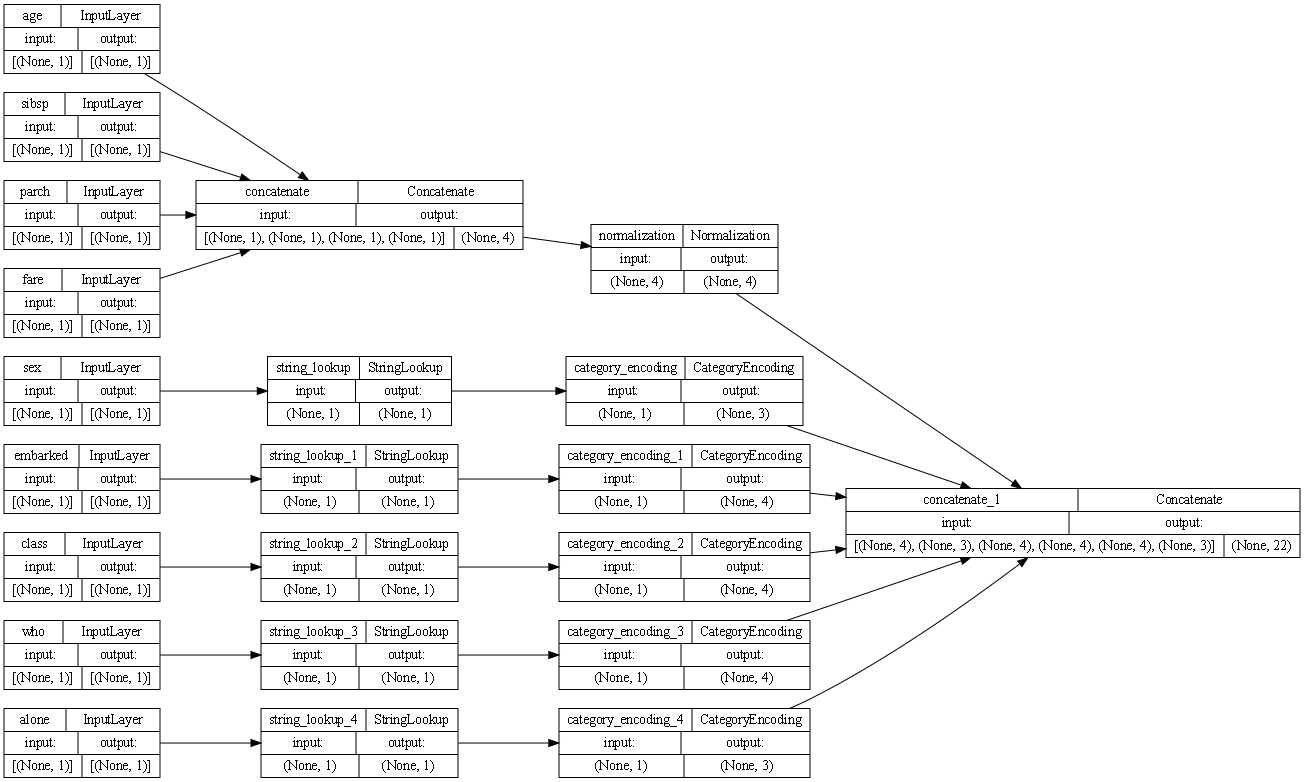

In [29]:
keras.utils.plot_model(preprocessor,show_shapes=True, rankdir="LR", dpi=72)

In [30]:
x_train_dict={name:np.array(column) for name,column in x_train.items()}

In [48]:
test_features_dict = {name:np.array(column[:1]) for name,column in x_train.items()}

In [32]:
test_features_dict

{'sex': array(['male'], dtype=object),
 'age': array([30.0232785]),
 'sibsp': array([8], dtype=int64),
 'parch': array([2], dtype=int64),
 'fare': array([69.55]),
 'embarked': array(['S'], dtype=object),
 'class': array(['Third'], dtype=object),
 'who': array(['man'], dtype=object),
 'alone': array(['n'], dtype=object)}

In [33]:
preprocessor(test_features_dict)

<tf.Tensor: shape=(1, 22), dtype=float32, numpy=
array([[6.5339538e-03, 7.0197134e+00, 1.9907279e+00, 7.0092964e-01,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [46]:
x_train_dict={name:np.array(column) for name,column in x_train.items()}
x_test_dict={name:np.array(column) for name,column in x_test.items()}
x_dev_dict={name:np.array(column) for name,column in x_dev.items()}

# create main model 

In [84]:
import os 

# checkpoint_path = "training_checkpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback_save = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq = 1000
)

In [99]:
del model

In [100]:
temp = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32,activation="tanh",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16,activation="leaky_relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(8,activation="leaky_relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dense(1,activation="sigmoid")
])

model = keras.Model(inputs , temp(preprocessor(inputs)))

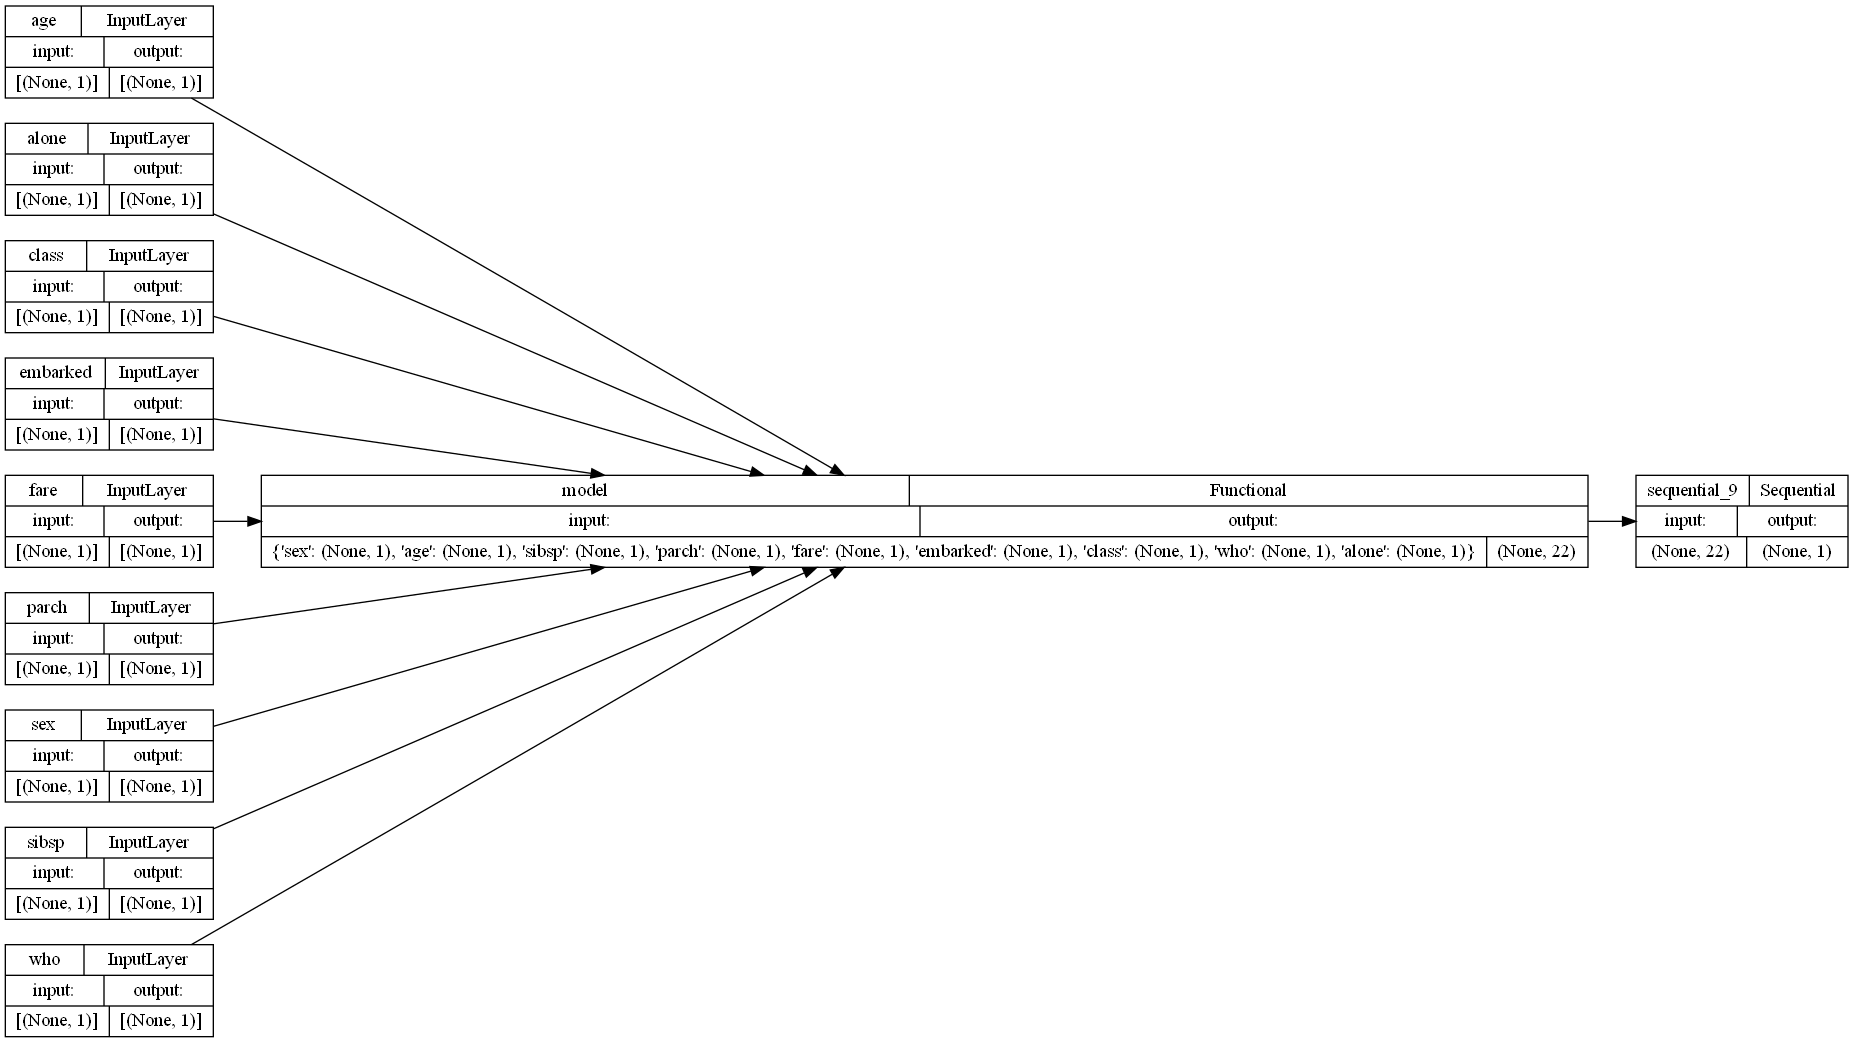

In [87]:
keras.utils.plot_model(model,rankdir="LR",show_shapes=True)

In [101]:
model.compile(
    optimizer="adam",
    loss = keras.losses.BinaryCrossentropy(),#from_logits=True),
    metrics = ["accuracy"]
)

In [103]:
model.fit(x_train_dict,y_train,epochs=1000,batch_size=534,validation_data=(x_dev_dict,y_dev),callbacks=[callback_save])

Epoch 1/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.2165 - accuracy: 0.9382 - val_loss: 0.9345 - val_accuracy: 0.7598
Epoch 2/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.2172 - accuracy: 0.9494 - val_loss: 0.9232 - val_accuracy: 0.7654
Epoch 3/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.2136 - accuracy: 0.9438 - val_loss: 0.9129 - val_accuracy: 0.7765
Epoch 4/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.2052 - accuracy: 0.9532 - val_loss: 0.9155 - val_accuracy: 0.7765
Epoch 5/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.2491 - accuracy: 0.9307 - val_loss: 0.9212 - val_accuracy: 0.7709
Epoch 6/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.2148 - accuracy: 0.9457 - val_loss: 0.9370 - val_accuracy: 0.7654
Epoch 7/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.1986 - accuracy: 0.9494 - val_loss: 0.9575 - val_accuracy: 0.7654
Epoch 8/

# orthogonalization

## first run 
we find out our model  can act better on training set or avoidable bias so we are going to 
improve network 

## second run 

we can achive 97% accuracy on train set but we have 70% accuracy on validation so we increase the avoidable bias but we have variance problem so in this part we ar going to fix it 

## third run 
so far i test all method of regularization including dropout , regularization itself and 
batch normalization . so the only way i have is to get more data i find out a newer version of titanic dataset with has 1380 data example and iwill use it too .

# get more data 

In [6]:
!pip install xlrd

   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/96.5 kB ? eta -:--:--
   ------------ --------------------------- 30.7/96.5 kB 330.3 kB/s eta 0:00:01
   ---------------- ----------------------- 41.0/96.5 kB 281.8 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
   ------------------------- -------------- 61.4/96.5 kB 363.1 kB/s e

In [3]:
#"C:\Users\ARMA\Desktop\github\tensorflow_tutorials\datasets\titanic3.xls"
dataset_2 = pd.read_excel("datasets/titanic3.xls")

In [197]:
dataset_2.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [198]:
np.sum(dataset_2.isnull())

c:\Users\ARMA\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [4]:
df_1 = dataset_2.drop(["name"],axis=1)

In [5]:
df_2 = df_1.copy()
df_2.body = df_1.body.apply(lambda x: 0 if pd.isnull(x) else 1)
df_2.boat = df_2.boat.apply(lambda x: 0 if pd.isnull(x) else 1)
df_2.cabin = df_2.cabin.apply(lambda x: 0 if pd.isnull(x) else 1)
df_2["home.dest"] = df_2["home.dest"].apply(lambda x: "other" if pd.isnull(x) else x)


In [6]:
df_2.pclass = df_2.pclass.astype(object)
df_2.sibsp = df_2.sibsp.astype(object)
df_2.parch = df_2.parch.astype(object)
df_2.cabin = df_2.cabin.astype(object)
df_2.boat = df_2.boat.astype(object)
df_2.body = df_2.body.astype(object)

def strm(x):
    return str(x)

df_2.pclass = df_2.pclass.apply(strm)
df_2.sibsp = df_2.sibsp.apply(strm)
df_2.parch = df_2.parch.apply(strm)
df_2.cabin = df_2.cabin.apply(strm)
df_2.boat = df_2.boat.apply(strm)
df_2.body = df_2.body.apply(strm)

In [202]:
df_2.dtypes

pclass        object
survived       int64
sex           object
age          float64
sibsp         object
parch         object
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body          object
home.dest     object
dtype: object

In [203]:
df_2.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,female,29.0000,0,0,24160,211.3375,1,S,1,0,"St Louis, MO"
1,1,1,male,0.9167,1,2,113781,151.5500,1,S,1,0,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,113781,151.5500,1,S,0,0,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,113781,151.5500,1,S,0,1,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,113781,151.5500,1,S,0,0,"Montreal, PQ / Chesterville, ON"


- check for outlier 

In [204]:
np.unique(df_2["age"])

array([ 0.1667,  0.3333,  0.4167,  0.6667,  0.75  ,  0.8333,  0.9167,
        1.    ,  2.    ,  3.    ,  4.    ,  5.    ,  6.    ,  7.    ,
        8.    ,  9.    , 10.    , 11.    , 11.5   , 12.    , 13.    ,
       14.    , 14.5   , 15.    , 16.    , 17.    , 18.    , 18.5   ,
       19.    , 20.    , 20.5   , 21.    , 22.    , 22.5   , 23.    ,
       23.5   , 24.    , 24.5   , 25.    , 26.    , 26.5   , 27.    ,
       28.    , 28.5   , 29.    , 30.    , 30.5   , 31.    , 32.    ,
       32.5   , 33.    , 34.    , 34.5   , 35.    , 36.    , 36.5   ,
       37.    , 38.    , 38.5   , 39.    , 40.    , 40.5   , 41.    ,
       42.    , 43.    , 44.    , 45.    , 45.5   , 46.    , 47.    ,
       48.    , 49.    , 50.    , 51.    , 52.    , 53.    , 54.    ,
       55.    , 55.5   , 56.    , 57.    , 58.    , 59.    , 60.    ,
       60.5   , 61.    , 62.    , 63.    , 64.    , 65.    , 66.    ,
       67.    , 70.    , 70.5   , 71.    , 74.    , 76.    , 80.    ,
           nan])

In [7]:
df_2[df_2['age']==0.1667]

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
763,3,1,female,0.1667,1,2,C.A. 2315,20.575,0,S,1,0,"Devon, England Wichita, KS"


as i can see we dont have outlier 

In [8]:
df_2.age = df_2.age.fillna(df_2.age.median())

In [9]:
type(df_2.embarked.mode().item())

str

In [10]:
df_2.fare = df_2.fare.fillna(df_2.fare.median())
df_2.embarked = df_2.embarked.fillna(df_2.embarked.mode().item())


In [209]:
df_2.embarked

0       S
1       S
2       S
3       S
4       S
       ..
1304    C
1305    C
1306    C
1307    C
1308    S
Name: embarked, Length: 1309, dtype: object

In [210]:
np.sum(df_2.isnull())

c:\Users\ARMA\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


pclass       0
survived     0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

In [211]:
np.unique(df_2.embarked)

array(['C', 'Q', 'S'], dtype=object)

In [212]:
np.unique(df_2["home.dest"]).shape


(370,)

i think destiny of the passanger doesnt effect their serviver and this feature has a very large set of diffrent value and will have a lot of feature_column after on hot encoding se i decide to delete it 

In [11]:
df_3 = df_2.drop("home.dest",axis=1)

In [214]:
df_3.head(5)

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
0,1,1,female,29.0000,0,0,24160,211.3375,1,S,1,0
1,1,1,male,0.9167,1,2,113781,151.5500,1,S,1,0
2,1,0,female,2.0000,1,2,113781,151.5500,1,S,0,0
3,1,0,male,30.0000,1,2,113781,151.5500,1,S,0,1
4,1,0,female,25.0000,1,2,113781,151.5500,1,S,0,0


In [215]:
df_3.describe()

,survived,age,fare
count,1309.000000,1309.000000,1309.000000
mean,0.381971,29.503183,33.281086
std,0.486055,12.905246,51.741500
min,0.000000,0.166700,0.000000
25%,0.000000,22.000000,7.895800
50%,0.000000,28.000000,14.454200
75%,1.000000,35.000000,31.275000
max,1.000000,80.000000,512.329200


In [12]:
df_3 = df_3.drop("ticket",axis=1)

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
x_train , x_temp , y_train , y_temp = train_test_split(df_3.drop("survived",axis=1),df_3["survived"],test_size=0.2)
x_dev , x_test , y_dev , y_test = train_test_split(x_temp,y_temp,test_size=0.4)

In [219]:
inputs ={}

for name , input_ in x_train.items():
    dtype = input_.dtype 
    if dtype == object :
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = keras.Input(shape=(1,),dtype=dtype , name=name)

print(inputs)

{'pclass': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'pclass')>, 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>, 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, 'sibsp': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sibsp')>, 'parch': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'parch')>, 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>, 'cabin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'cabin')>, 'embarked': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embarked')>, 'boat': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'boat')>, 'body': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'body')>}


In [220]:
numeric_inputs = {name:input_ for name,input_ in inputs.items() if input_.dtype == tf.float32}

norm = layers.Normalization()
norm.adapt(x_train[numeric_inputs.keys()])

temp = layers.Concatenate()(list(numeric_inputs.values()))

preprocessed_numeric_inputs = norm(temp)

In [221]:
preprocessed_inputs = [preprocessed_numeric_inputs]

In [222]:
for name,input_ in inputs.items():

    if input_.dtype == tf.float32:
        continue 

    
    lookup = layers.StringLookup(vocabulary=np.unique(df_3[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input_)
    x = one_hot(x)
    # lookup = layers.StringLookup(vocabulary=np.unique(df_3[name])) 
    # one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    # print(lookup.vocabulary_size())
    # x = lookup(input_)
    # y = one_hot(x)

    # preprocessed_inputs.append(y)
    # print(len(preprocessed_inputs))

    preprocessed_inputs.append(x)

In [223]:
preprocessor = keras.Model(inputs,layers.Concatenate()(preprocessed_inputs))

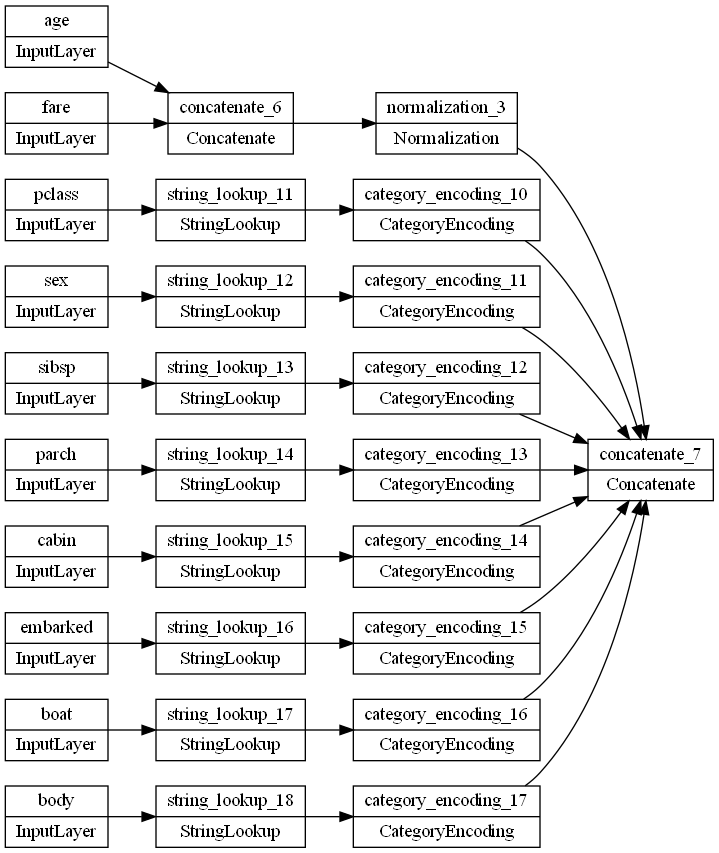

In [224]:
keras.utils.plot_model(preprocessor,rankdir="LR")

In [231]:
test_features_dict = {name:np.array(column[:1]) for name,column in x_train.items()}

In [233]:
preprocessor(test_features_dict)

TensorShape([1, 39])

In [225]:
type(x_train)

pandas.core.frame.DataFrame

In [234]:
x_train_dict = {name:np.array(column) for name,column in x_train.items()}
x_test_dict = {name:np.array(column) for name,column in x_test.items()}
x_dev_dict = {name:np.array(column) for name,column in x_dev.items()}

In [262]:
del model 

In [263]:
#  temp_model = keras.Sequential([
#     #layers.BatchNormalization(),
#     layers.Dense(40,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     #layers.BatchNormalization(),
#     #layers.Dropout(0.2),
#     layers.Dense(40,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     #layers.BatchNormalization(),
#     #layers.Dropout(0.2),
#     layers.Dense(80,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     #layers.BatchNormalization(),
#     #layers.Dropout(0.2),
    # layers.Dense(80,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # #layers.BatchNormalization(),
    # #layers.Dropout(0.2),
    # layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # #layers.BatchNormalization(),
    # #layers.Dropout(0.2),
    # layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # #layers.BatchNormalization(),
    # layers.Dense(1280,activation="tanh"),#,kernel_regularizer=keras.regularizers.L2()),
    # layers.Dense(5120,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # layers.Dense(1280,activation="tanh"),#,kernel_regularizer=keras.regularizers.L2()),
    # layers.Dense(1280,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
    # layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(320,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(80,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(80,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(20,activation="relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(20,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(10,activation="leaky_relu"),#,kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(1,activation="sigmoid")
# ])

temp_model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid"),

])
y = temp_model(preprocessor(inputs))
model = keras.Model(inputs , y)

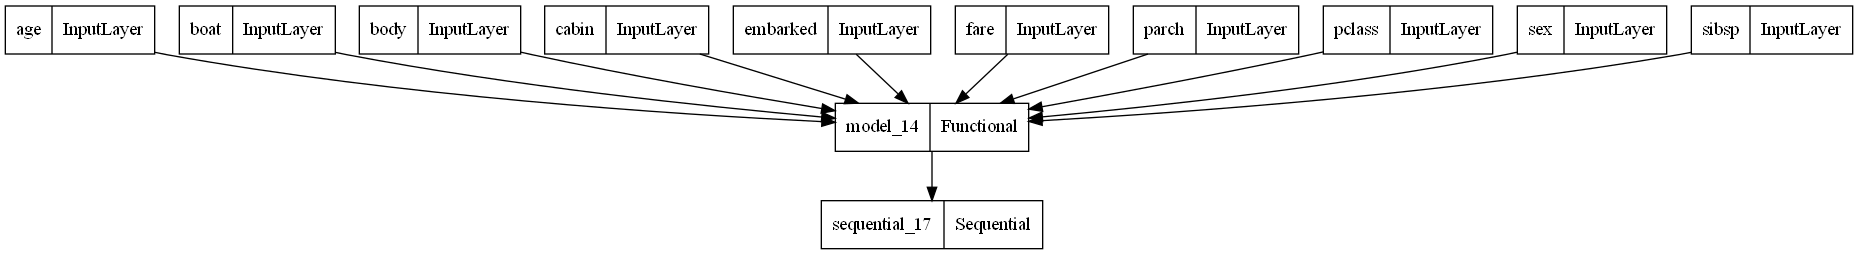

In [264]:
keras.utils.plot_model(model)

In [280]:
model(test_features_dict)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.97208375]], dtype=float32)>

In [266]:
global_step = tf.Variable(0,trainable = False)
learning_rate_decayed = tf.compat.v1.train.inverse_time_decay(0.001,global_step,1,1)

In [267]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate_decayed),
    loss = keras.losses.BinaryCrossentropy(),#from_logits=True),
    metrics = ["accuracy"]
)

In [268]:
x_train.shape

(1047, 10)

In [272]:
history = model.fit(x_train_dict,y_train,epochs=199,batch_size=256,validation_data=(x_dev_dict,y_dev))

Epoch 1/199
1/5 [=====>........................] - ETA: 0s - loss: 0.1714 - accuracy: 0.9766

5/5 [==============================] - 0s 68ms/step - loss: 0.1404 - accuracy: 0.9809 - val_loss: 0.1611 - val_accuracy: 0.9682
Epoch 2/199
5/5 [==============================] - 0s 31ms/step - loss: 0.1279 - accuracy: 0.9809 - val_loss: 0.1600 - val_accuracy: 0.9745
Epoch 3/199
5/5 [==============================] - 0s 36ms/step - loss: 0.1286 - accuracy: 0.9780 - val_loss: 0.1587 - val_accuracy: 0.9745
Epoch 4/199
5/5 [==============================] - 0s 35ms/step - loss: 0.1201 - accuracy: 0.9790 - val_loss: 0.1561 - val_accuracy: 0.9682
Epoch 5/199
5/5 [==============================] - 0s 51ms/step - loss: 0.1196 - accuracy: 0.9799 - val_loss: 0.1529 - val_accuracy: 0.9554
Epoch 6/199
5/5 [==============================] - 0s 34ms/step - loss: 0.1309 - accuracy: 0.9809 - val_loss: 0.1514 - val_accuracy: 0.9682
Epoch 7/199
5/5 [==============================] - 0s 29ms/step - loss: 0.1141 - accuracy: 0.9828 - val_loss: 0.1662 - val_accuracy: 0.9682
Epoch 8/199
5/5 [===============

In [270]:
import matplotlib.pyplot as plt 

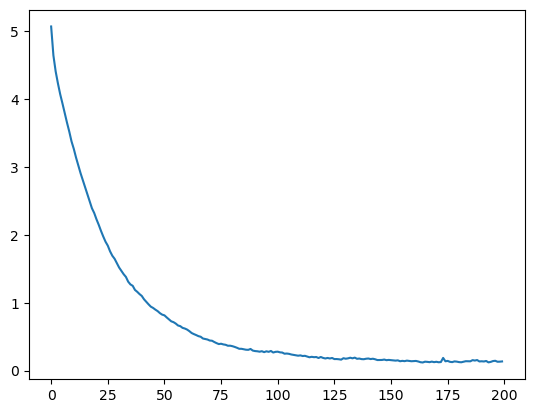

In [271]:
plt.plot(history.history["loss"])

# iteration analysis 

## forth run 

in this run we get about 400 hundred extra data but our result get worther so i will move to my new idea . its about decreasing batch size for increassing gradient steps 

## fifth run 

changing batch size doesnt work eaither 
so as we have bias problem now i will go and change artitucture now 

## sixth run 

i think to my self what if i increase the number of neuruon slowly from ten and then decrease them slowly to 1 like a mountain . (and right now i wait for training result :)) )

the reasult show that our idea worked but in the next run 

## seventh run 

from previous run we find out our loss is soo noisy so i increase the batch size and according to history of training after 800 epochs we dont see any big change so i increase epochs number too . in this run i increas the number of neurons in some layers . and i add some tanh function for more non linearity 

## eighth run

in this run we will apply learining rate decay for faster performance and bigger net work 

## ninth run 

after appy ing learning rate decay i get very static and constant result 
i think i should change learning rate decay setting . i think to my self previously we had a much smaller network and model but we got a 95% accuracy on train set . i think we have some issue with preprocessing so i go back and unnormalize the categorical feature

## tenth run 

in this run after we fix learining rate decay algorithm and train data set we get a very good result . in the next run we use some regularization tecknic for decrease the variance even more . currently we got 99% in train and 96% in test . 

## eleventh run 
with dropout we get even better result on dec 97% 

## twelve run 

with batch normalization we get same result in less epochs 

## thirteenth run 
we apply l2 regularization and get the same result but training loss is more smother 




In [275]:
model.evaluate(x_test_dict,y_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.1217 - accuracy: 0.9810


[0.1216697245836258, 0.9809523820877075]

as you can see we got 98% accuracy on test set with is very good 
so we dont have these problem :

- avoidable bias 
- variance 
- mismach data

## last run 

we are going to selete some postfacto like body and boat ant trian again 

In [13]:
df_3 = df_3.drop(["body","boat"],axis=1)

In [14]:
x_train , x_temp , y_train , y_temp = train_test_split(df_3.drop("survived",axis=1),df_3["survived"],test_size=0.2)
x_dev , x_test , y_dev , y_test = train_test_split(x_temp,y_temp,test_size=0.4)

In [15]:
inputs ={}

for name , input_ in x_train.items():
    dtype = input_.dtype 
    if dtype == object :
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = keras.Input(shape=(1,),dtype=dtype , name=name)

print(inputs)


{'pclass': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'pclass')>, 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>, 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, 'sibsp': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sibsp')>, 'parch': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'parch')>, 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>, 'cabin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'cabin')>, 'embarked': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embarked')>}


In [16]:
numeric_inputs = {name:input_ for name,input_ in inputs.items() if input_.dtype == tf.float32}

norm = layers.Normalization()
norm.adapt(x_train[numeric_inputs.keys()])

temp = layers.Concatenate()(list(numeric_inputs.values()))

preprocessed_numeric_inputs = norm(temp)

In [17]:
preprocessed_inputs = [preprocessed_numeric_inputs]

In [18]:
for name,input_ in inputs.items():

    if input_.dtype == tf.float32:
        continue 

    
    lookup = layers.StringLookup(vocabulary=np.unique(df_3[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input_)
    x = one_hot(x)
    # lookup = layers.StringLookup(vocabulary=np.unique(df_3[name])) 
    # one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    # print(lookup.vocabulary_size())
    # x = lookup(input_)
    # y = one_hot(x)

    # preprocessed_inputs.append(y)
    # print(len(preprocessed_inputs))

    preprocessed_inputs.append(x)

In [19]:
preprocessor = keras.Model(inputs,layers.Concatenate()(preprocessed_inputs))

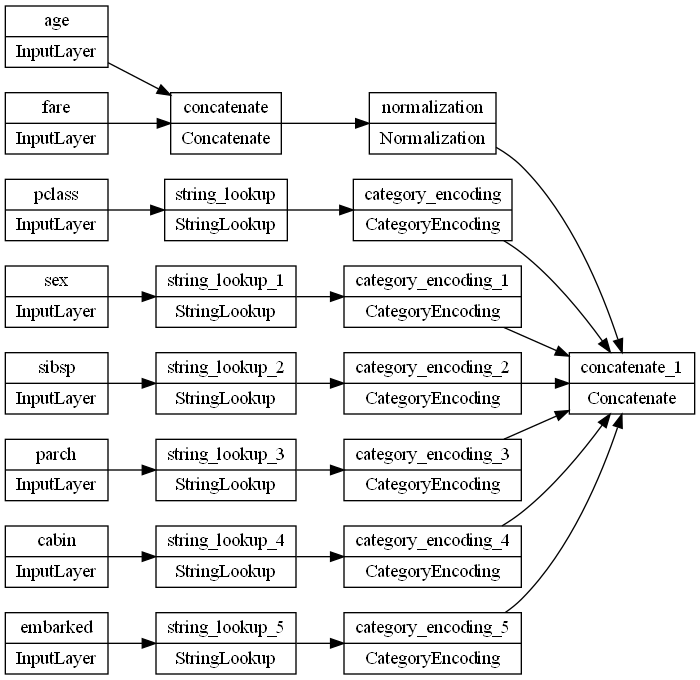

In [20]:
keras.utils.plot_model(preprocessor,rankdir="LR")

In [21]:
test_features_dict = {name:np.array(column[:1]) for name,column in x_train.items()}

In [22]:
preprocessor(test_features_dict)

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 0.8005036 , -0.12066305,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ]], dtype=float32)>

In [23]:
type(x_train)

pandas.core.frame.DataFrame

In [24]:
x_train_dict = {name:np.array(column) for name,column in x_train.items()}
x_test_dict = {name:np.array(column) for name,column in x_test.items()}
x_dev_dict = {name:np.array(column) for name,column in x_dev.items()}

In [181]:
del model 

In [182]:
# temp_modle = keras.Sequential([
#     layers.Dense(512,activation="relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(256,activation="relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(64,activation="leaky_relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(32,activation="leaky_relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(16,activation="leaky_relu",kernel_regularizer=keras.regularizers.L2()),
#     layers.Dense(8,activation="leaky_relu"),
#     layers.Dense(4,activation="leaky_relu"),
#     layers.Dense(2,activation="tanh"),
#     layers.Dense(1,activation="tanh"),
#     layers.Dense(1)
# ])

temp_modle = keras.Sequential([
    layers.Dense(3,activation="relu"),
    layers.Dense(2,activation="tanh"),
    layers.Dense(1),
])    

y = temp_model(preprocessor(inputs))
model = keras.Model(inputs , y)

In [183]:
global_step = tf.Variable(0,trainable = False)
learning_rate_decayed = tf.compat.v1.train.inverse_time_decay(0.001,global_step,3,1)
#learning_rate_decayed = tf.compat.v1.train.exponential_decay(1.,global_step,1,0.7)#,staircase=True)


In [184]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate_decayed),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [185]:
history = model.fit(x_train_dict,y_train,epochs=100,batch_size=256,validation_data=(x_dev_dict,y_dev))

Epoch 1/100


c:\Users\ARMA\anaconda3\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 5s 261ms/step - loss: 0.2882 - accuracy: 0.8911 - val_loss: 0.9341 - val_accuracy: 0.7197
Epoch 2/100
5/5 [==============================] - 0s 40ms/step - loss: 0.2650 - accuracy: 0.8968 - val_loss: 0.8960 - val_accuracy: 0.7261
Epoch 3/100
5/5 [==============================] - 0s 39ms/step - loss: 0.2600 - accuracy: 0.8930 - val_loss: 0.8194 - val_accuracy: 0.7261
Epoch 4/100
5/5 [==============================] - 0s 40ms/step - loss: 0.2524 - accuracy: 0.9016 - val_loss: 0.8795 - val_accuracy: 0.7134
Epoch 5/100
5/5 [==============================] - 0s 44ms/step - loss: 0.2505 - accuracy: 0.8988 - val_loss: 0.9102 - val_accuracy: 0.7197
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.2456 - accuracy: 0.9007 - val_loss: 0.8903 - val_accuracy: 0.7325
Epoch 7/100
5/5 [==============================] - 0s 40ms/step - loss: 0.2419 - accuracy: 0.8988 - val_loss: 0.8191 - val_accuracy: 0.7580
Epoch 8/100
5/5 [==============

In [186]:
model.evaluate(x_test_dict,y_test)

4/4 [==============================] - 0s 5ms/step - loss: 1.0904 - accuracy: 0.7048


[1.090396523475647, 0.7047619223594666]

In [187]:
import matplotlib.pyplot as plt 

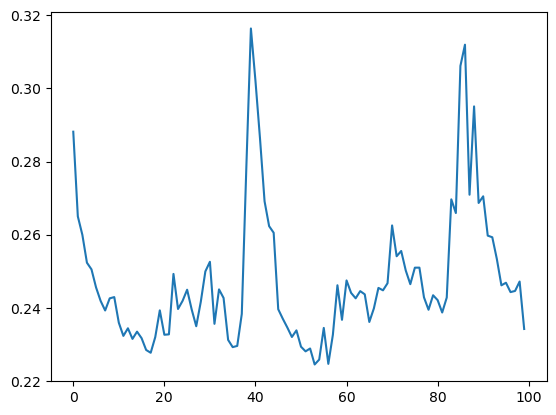

In [188]:
plt.plot(history.history["loss"])
# plt.xlim([1950,2000])
# plt.ylim([0,0.3])

In [189]:
model.save("goodmodel")

INFO:tensorflow:Assets written to: goodmodel\assets


INFO:tensorflow:Assets written to: goodmodel\assets


as you can see my idea is right 

in the one off the model we get 77% accuracy on test set 